In [1]:
import mne
import scipy
import numpy as np
import matplotlib.pyplot as plt
import utils
import os
import glob
from scipy.stats import zscore, pearsonr
from scipy.io import savemat, loadmat
from scipy import signal
%matplotlib widget

## Data preparation

**EEG signals:** Load EEGLAB datasets -> Re-reference -> Highpass filter -> downsample

**Features of the video:** Extracted with Dmochowski's code (https://github.com/dmochow/SRC)

In [2]:
%%capture 
# to supress the outputs
# Names and paths
eeg_path_head = '../../Experiments/data/AS/Videos/'
feature_path_head = '../../Experiments/Videos/'
videonames, eeg_sets_paths, feature_sets_paths = utils.name_paths(eeg_path_head, feature_path_head)
# Load single experiment
# idx = 1
# eeg_downsampled, normalized_features, times, fs = utils.load_eeg_feature(idx, videonames, eeg_sets_paths, feature_sets_paths)
# Load all experiments
eeg_downsampled, normalized_features, times, fs = utils.concatenate_eeg_feature(videonames, eeg_sets_paths, feature_sets_paths, feature_type='muFlow')

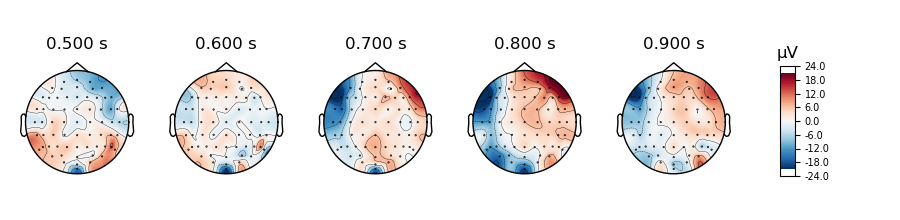

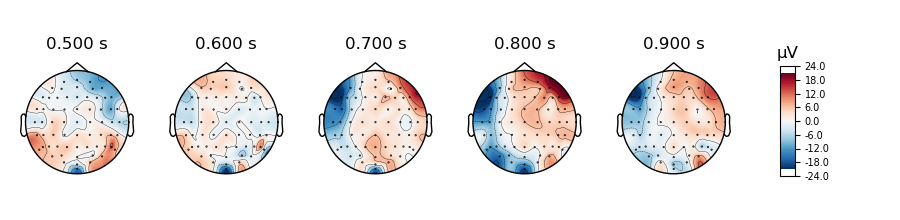

In [71]:
# Visualization
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=fs)
create_info.set_montage('biosemi64')
evoked = mne.EvokedArray(eeg_downsampled.T, create_info)
plt.close()
# evoked.plot_topomap(times=[i*60 for i in range(30)])
evoked.plot_topomap(times=[0.1*i for i in range(5,10)])
# The occipital lobes sit at the back of the head and are responsible for visual perception, including colour, form and motion.
plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows


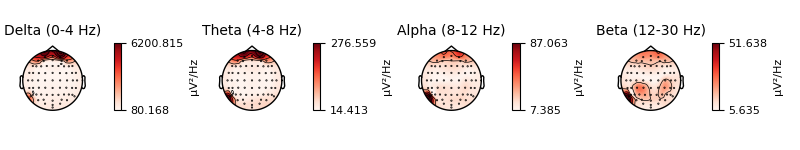

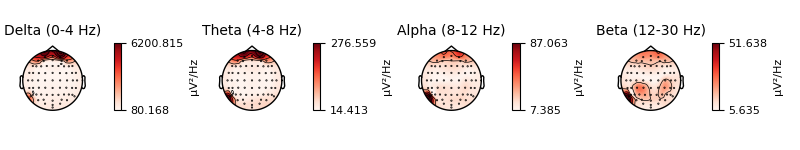

In [53]:
bands = {'Delta (0-4 Hz)': (0, 4), 'Theta (4-8 Hz)': (4, 8),
         'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30)}
plt.close()
# bands = [(1, 5), (6, 10), (11, 15), (16, 20), (21, 25), (26, 30)]
evoked.compute_psd().plot_topomap(bands=bands)
plt.show()

### Use multichannel Wiener filter to do artifacts removal (mainly eye-blink artifacts)

Matlab toolbox: https://github.com/exporl/mwf-artifact-removal

Reference: Somers, B., Francart, T. and Bertrand, A. (2018). A generic EEG artifact removal algorithm based on the multi-channel Wiener filter. Journal of Neural Engineering, 15(3), 036007. DOI: 10.1088/1741-2552/aaac92

In [3]:
# savemat('../../Experiments/data/AS/Videos/eeg_concat.mat', {'eegdata': eeg_downsampled.T, 'fs': fs})

In [ ]:
eeg_downsampled = loadmat('../../Experiments/data/AS/Videos/clean_eeg.mat')['clean_eeg']
eeg_downsampled = eeg_downsampled.T

## CCA

Run canonical component analysis

In [3]:
L_timefilter = int(fs)
n_components = 5
# Find the convolution matrix and run CCA (with all data)
conv_mtx = utils.convolution_mtx(L_timefilter, normalized_features)
corr_coe, p_value, V_A, V_B = utils.cano_corr(eeg_downsampled, conv_mtx, n_components=n_components, regularizaion=None)
filtered_EEG = eeg_downsampled@V_A
filtered_Sti = conv_mtx@V_B
print('Note: no unseen data')
print('Correlation coefficients of the top {} components: {}'.format(n_components, corr_coe))
print('P-values of the top {} components: {}'.format(n_components, p_value))

Note: no unseen data
Correlation coefficients of the top 5 components: [0.21439551 0.14415749 0.08652847 0.07017753 0.04819492]
P-values of the top 5 components: [0.00000000e+000 7.80635048e-244 1.51675712e-088 8.31258165e-059
 1.29588589e-028]


In [19]:
T, D = eeg_downsampled.shape
datalist = [eeg_downsampled, conv_mtx]
_, W = utils.GCCA_multi_modal(datalist, n_components=n_components, regularization='lwcov')
W_EEG = W[:D,:]
W_Stim = W[D:D+L_timefilter,:]
EEG_trans = eeg_downsampled@W_EEG
Stim_trans = conv_mtx@W_Stim
corr_pvalue = [pearsonr(EEG_trans[:,k], Stim_trans[:,k]) for k in range(n_components)]
corr_coe = np.array([corr_pvalue[k][0] for k in range(n_components)])
corr_coe

array([0.09645727, 0.073176  , 0.0278796 , 0.04640596, 0.02974413])

In [20]:
utils.avg_corr_coe_multi_modal(datalist, [W_EEG, W_Stim], n_components=5)

array([0.09645727, 0.073176  , 0.0278796 , 0.04640596, 0.02974413])

In [18]:
# Cross validation
fold = 10
corr_train = np.zeros((fold, n_components))
corr_test = np.zeros((fold, n_components))
for idx in range(fold):
    EEG_train, EEG_test, Sti_train, Sti_test = utils.split(eeg_downsampled, normalized_features, fold=fold, fold_idx=idx+1)
    conv_mtx_train = utils.convolution_mtx(L_timefilter, Sti_train)
    corr_train[idx,:], p_value_train, V_A_train, V_B_train = utils.cano_corr(EEG_train, conv_mtx_train, n_components=n_components, regularizaion=None)
    conv_mtx_test = utils.convolution_mtx(L_timefilter, Sti_test)
    corr_test[idx,:], p_value_test, _, _ = utils.cano_corr(EEG_test, conv_mtx_test, n_components=n_components, V_A=V_A_train, V_B=V_B_train)
print('Average correlation coefficients of the top {} components on the training sets: {}'.format(n_components, np.average(corr_train, axis=0)))
print('Average correlation coefficients of the top {} components on the test sets: {}'.format(n_components, np.average(corr_test, axis=0)))

Average correlation coefficients of the top 5 components on the training sets: [0.21611985 0.14705398 0.08886044 0.07320228 0.05062475]
Average correlation coefficients of the top 5 components on the test sets: [0.18848861 0.08758986 0.0471603  0.0163097  0.00247928]


correlation coefficient = [0.17249773 0.12538798 0.07044199 0.00597393 0.02770222], p-value = [8.39763076e-72 1.61635181e-38 3.55345456e-13 5.37950939e-01
 4.28161046e-03]%


100%|██████████| 1000/1000 [00:09<00:00, 101.42it/s]


Component 3, top 0.0%


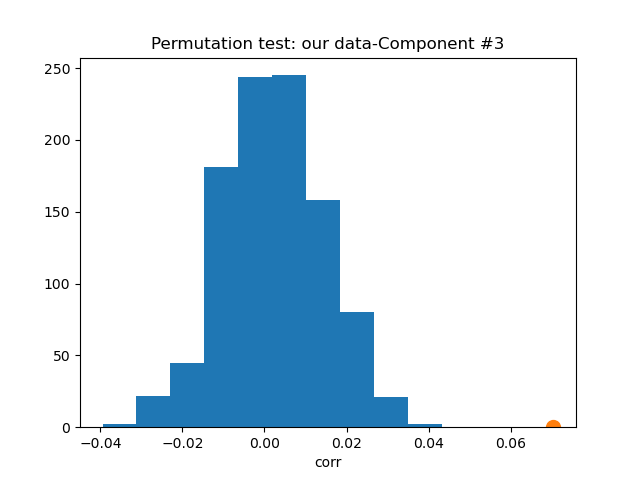

In [62]:
# Permutation test
fold = 5
idx = 4
EEG_train, EEG_test, Sti_train, Sti_test = utils.split(eeg_downsampled, normalized_features, fold=fold, fold_idx=idx+1)
conv_mtx_train = utils.convolution_mtx(L_timefilter, Sti_train)
corr_train, _, V_A_train, V_B_train = utils.cano_corr(EEG_train, conv_mtx_train, n_components=n_components)
conv_mtx_test = utils.convolution_mtx(L_timefilter, Sti_test)
corr_test, p_value_test, _, _ = utils.cano_corr(EEG_test, conv_mtx_test, n_components=n_components, V_A=V_A_train, V_B=V_B_train)
print("correlation coefficient = {}, p-value = {}%".format(corr_test, p_value_test))
num_test=1000
corr_coe_topK = utils.permutation_test(EEG_test, np.squeeze(Sti_test, axis=1), num_test, t=1, fs=fs, topK=n_components, V_A=V_A_train, V_B=V_B_train)

compo = 3
corr_coe_list = corr_coe_topK[:,compo-1]
signifi = sum(corr_coe_topK[:,compo-1]>corr_test[compo-1])/num_test*100
print("Component {compo}, top {signifi}%".format(compo=compo, signifi=signifi))
plt.close()
plt.hist(corr_coe_topK[:,compo-1])
plt.title('Permutation test: our data-'+'Component #'+str(compo))
plt.xlabel('corr')
plt.plot(corr_test[compo-1], 0, marker="o", markersize=10)
plt.show()


### Temporal filters

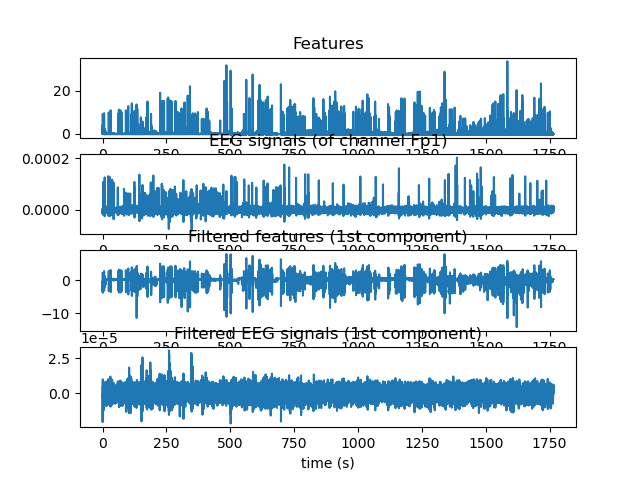

In [18]:
# Visualizations of component 1
plt.close()
compo = 1
ax1 = plt.subplot(411)
ax1.plot(times, normalized_features)
ax1.title.set_text('Features')
ax2 = plt.subplot(412, sharex = ax1)
ax2.plot(times, eeg_downsampled[:,0])
ax2.title.set_text('EEG signals (of channel Fp1)')
ax3 = plt.subplot(413, sharex = ax1)
ax3.plot(times, filtered_Sti[:,compo-1])
ax3.title.set_text('Filtered features (1st component)')
ax4 = plt.subplot(414, sharex = ax1)
ax4.plot(times, filtered_EEG[:,compo-1])
ax4.title.set_text('Filtered EEG signals (1st component)')
ax4.set_xlabel('time (s)')
plt.show()

In [19]:
dt = times[1]-times[0]
grad = np.gradient(np.squeeze(normalized_features), dt)
grad_2 = np.gradient(grad, dt)
grad_3 = np.gradient(grad_2, dt)

In [20]:
V_B[:,compo-1]

array([ 0.25095725,  0.20967705,  0.17876361,  0.10580495, -0.05915983,
       -0.09921269, -0.16778182, -0.31044721, -0.35903155, -0.32536406,
       -0.29965924, -0.25738722, -0.25913222, -0.22776557, -0.2019888 ,
       -0.20459776, -0.16445571, -0.12706654, -0.0685287 , -0.05108542,
       -0.01466444, -0.01526092,  0.01005344,  0.05908161,  0.07241543,
        0.06815024,  0.08984864,  0.10657185,  0.12075589,  0.14525861])

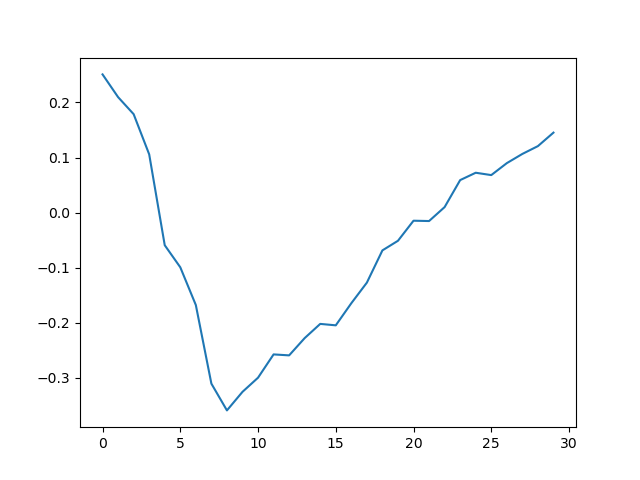

In [21]:
plt.close()
plt.plot(range(len(V_B[:,compo-1])), V_B[:,compo-1])
plt.show()

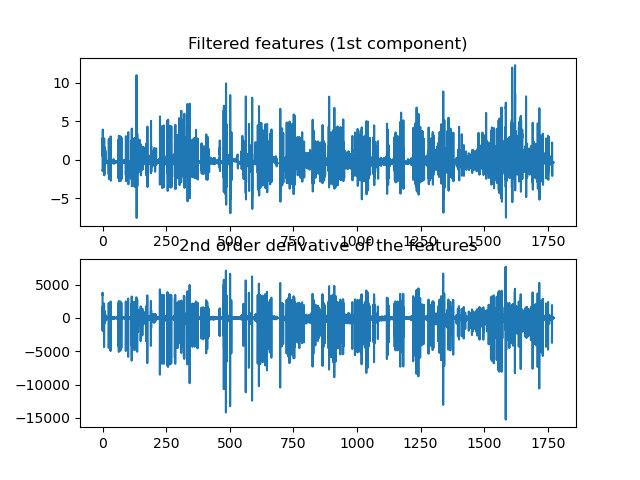

In [13]:
plt.close()
ax1 = plt.subplot(211)
ax1.plot(times, filtered_Sti[:,compo-1])
ax1.title.set_text('Filtered features (1st component)')
ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(times, grad_2)
ax2.title.set_text('2nd order derivative of the features')
plt.show()

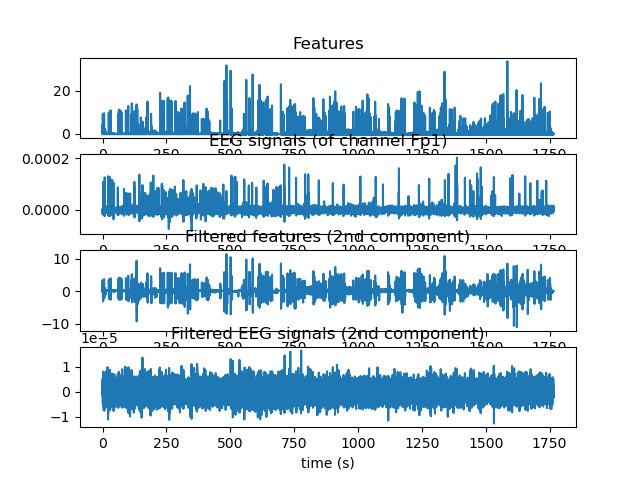

In [25]:
# Visualizations of component 2
plt.close()
compo = 2
ax1 = plt.subplot(411)
ax1.plot(times, normalized_features)
ax1.title.set_text('Features')
ax2 = plt.subplot(412, sharex = ax1)
ax2.plot(times, eeg_downsampled[:,0])
ax2.title.set_text('EEG signals (of channel Fp1)')
ax3 = plt.subplot(413, sharex = ax1)
ax3.plot(times, filtered_Sti[:,compo-1])
ax3.title.set_text('Filtered features (2nd component)')
ax4 = plt.subplot(414, sharex = ax1)
ax4.plot(times, filtered_EEG[:,compo-1])
ax4.title.set_text('Filtered EEG signals (2nd component)')
ax4.set_xlabel('time (s)')
plt.show()

In [26]:
V_B[:,compo-1]

array([ 0.13800306,  0.16082861,  0.19072963,  0.34639225,  0.35793717,
        0.2540262 ,  0.09927396,  0.08347735,  0.08512597,  0.17206336,
        0.14821625,  0.05764922, -0.02180309, -0.1044043 , -0.10304407,
       -0.07911349, -0.11917071, -0.17544625, -0.20962042, -0.21376462,
       -0.20982717, -0.2153244 , -0.24813286, -0.22851328, -0.18114064,
       -0.20355557, -0.15949772, -0.20730281, -0.0991307 , -0.08699668])

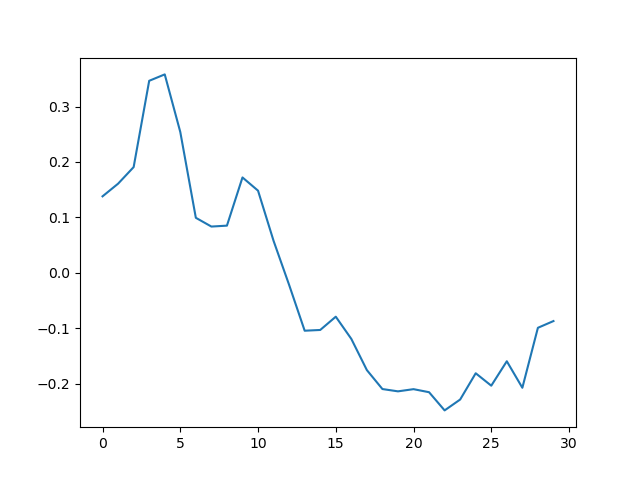

In [27]:
plt.close()
plt.plot(range(len(V_B[:,compo-1])), V_B[:,compo-1])
plt.show()

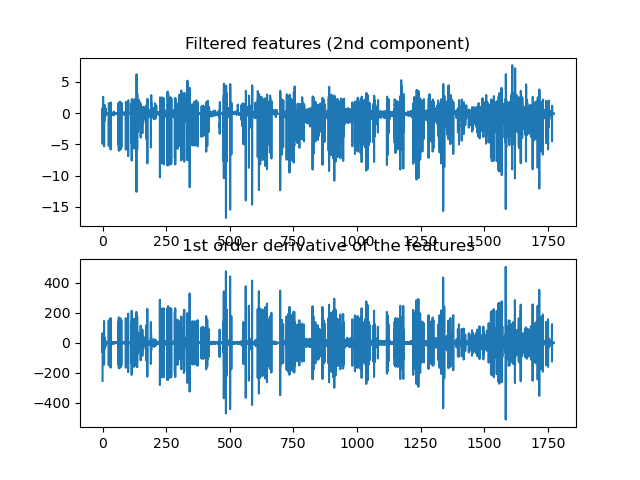

In [17]:
plt.close()
ax1 = plt.subplot(211)
ax1.plot(times, filtered_Sti[:,compo-1])
ax1.title.set_text('Filtered features (2nd component)')
ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(times, grad)
ax2.title.set_text('1st order derivative of the features')
plt.show()

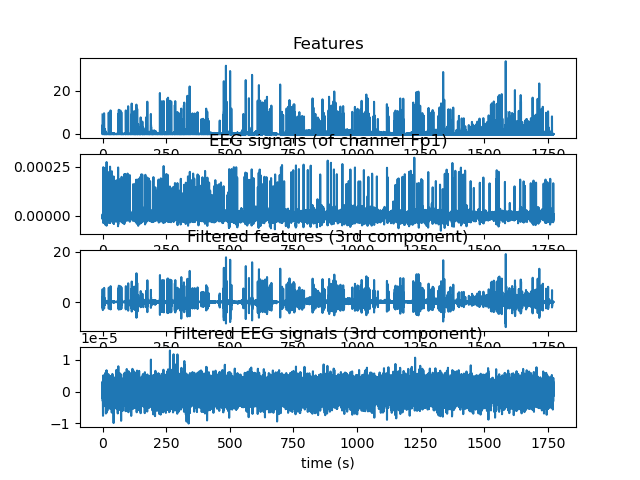

In [18]:
# Visualizations of component 3
plt.close()
compo = 3
ax1 = plt.subplot(411)
ax1.plot(times, normalized_features)
ax1.title.set_text('Features')
ax2 = plt.subplot(412, sharex = ax1)
ax2.plot(times, eeg_downsampled[:,0])
ax2.title.set_text('EEG signals (of channel Fp1)')
ax3 = plt.subplot(413, sharex = ax1)
ax3.plot(times, filtered_Sti[:,compo-1])
ax3.title.set_text('Filtered features (3rd component)')
ax4 = plt.subplot(414, sharex = ax1)
ax4.plot(times, filtered_EEG[:,compo-1])
ax4.title.set_text('Filtered EEG signals (3rd component)')
ax4.set_xlabel('time (s)')
plt.show()

In [19]:
V_B[:,compo-1]

array([ 0.01549082,  0.07021   , -0.04792578, -0.04003241, -0.2667406 ,
       -0.18475134,  0.27927602,  0.56824726,  0.47575052,  0.20756753,
        0.04770925, -0.14204444, -0.23844835, -0.21996533, -0.15176594,
       -0.1303344 , -0.07037629, -0.06221303, -0.10032965, -0.10878152,
       -0.01658528,  0.02208801,  0.02526636, -0.02733914,  0.04079432,
        0.05684795, -0.02184662, -0.04308295, -0.08406235, -0.0210298 ])

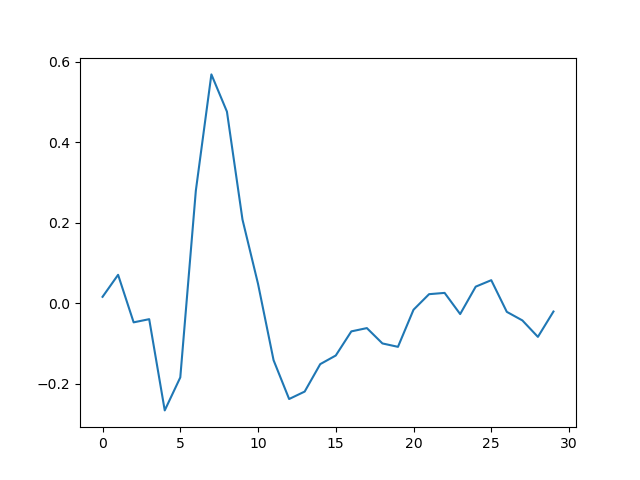

In [20]:
plt.close()
plt.plot(range(len(V_B[:,compo-1])), V_B[:,compo-1])
plt.show()

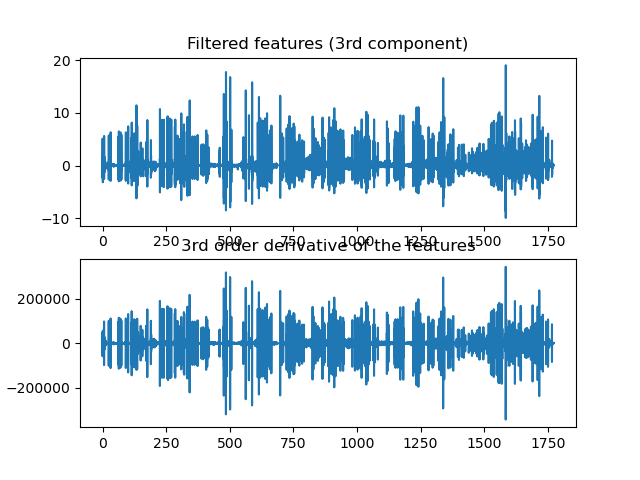

In [21]:
plt.close()
ax1 = plt.subplot(211)
ax1.plot(times, filtered_Sti[:,compo-1])
ax1.title.set_text('Filtered features (3rd component)')
ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(times, grad_3)
ax2.title.set_text('3rd order derivative of the features')
plt.show()

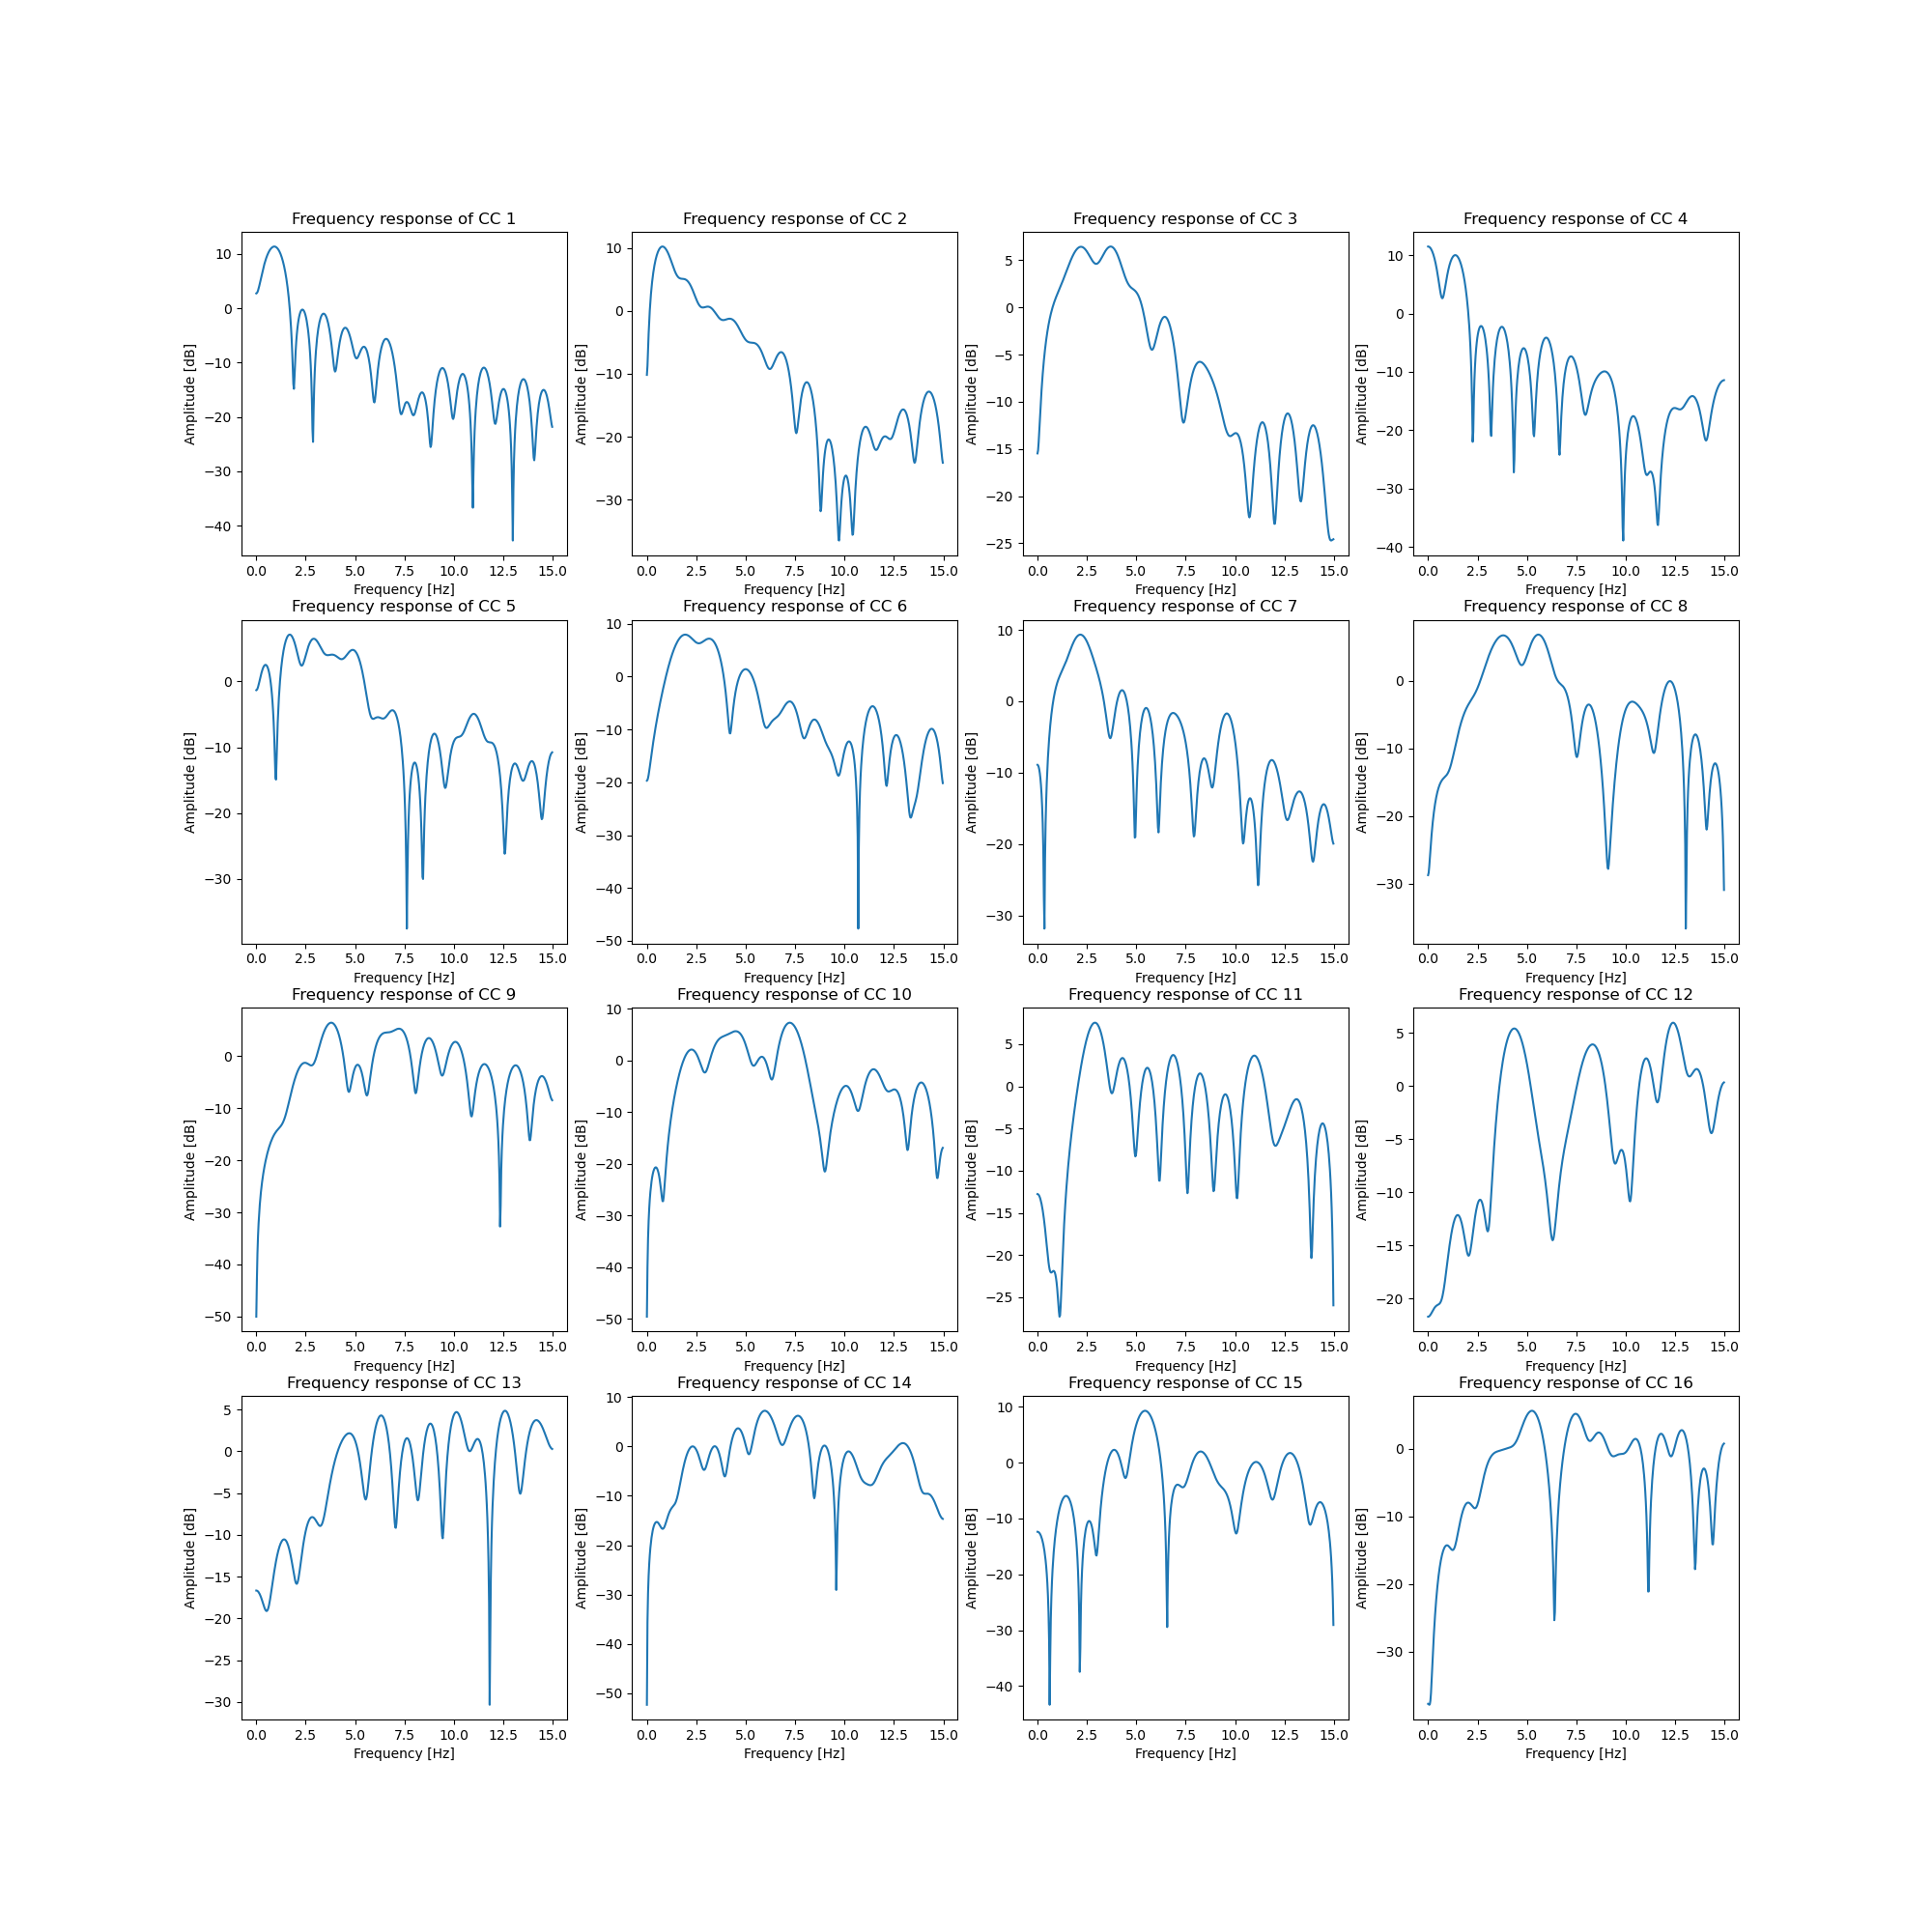

In [46]:
_, _, _, V_B = utils.cano_corr(eeg_downsampled, conv_mtx, n_components=16, regularizaion='None')
plt.figure(figsize=(20, 20))
for i in range(16):
    w, h = signal.freqz(b=V_B[:,i], a=1)
    x = w * fs * 1.0 / (2 * np.pi)
    y = 20 * np.log10(abs(h))
    ax = plt.subplot(4, 4, i + 1)
    ax.plot(x,y)
    ax.set_ylabel('Amplitude [dB]')
    ax.set_xlabel('Frequency [Hz]')
    ax.set_title('Frequency response of CC '+str(i+1))
    # plt.grid(which='both', linestyle='-', color='grey')
    # plt.xticks([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000], ["20", "50", "100", "200", "500", "1K", "2K", "5K", "10K", "20K"])
# plt.show()

### Spatial filters

In [14]:
regu = None
# regu = 'lwcov'
_, _, V_A, _ = utils.cano_corr(eeg_downsampled, conv_mtx, n_components=6, regularizaion=regu)
forward_model = utils.forward_model(eeg_downsampled, V_A, regularization=regu)

In [ ]:
# Visualization:
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')
plt.close()
plt.figure()
# plt.figure(figsize=(20, 20))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    mne.viz.plot_topomap(forward_model[:,i], create_info, ch_type='eeg', axes=ax)
    ax.set_title('CC '+str(i+1))
plt.show()

## GCCA

In [4]:
%%capture
subjects = ['AS', 'YY']
# videos = ['Dr', 'Parra', 'Safety', 'Spring']
videos = ['Spring']
feature_type = 'muFlow'
features_list = []
eeg_multisub_list = []
for video in videos:
    features, eeg_multisub, fs, _ = utils.multisub_data_org(subjects, video, feature_type=feature_type)
    features_list.append(features)
    eeg_multisub_list.append(eeg_multisub)
feature_concat = np.concatenate(tuple(features_list), axis=0)
eeg_multisub_concat = np.concatenate(tuple(eeg_multisub_list), axis=0)
T = feature_concat.shape[0]
times = np.array(range(T))/fs

In [5]:
L_timefilter = int(fs)
n_components = 5
fold = 10
# GCCA-one subject + stimulus
# rhos = [1, 1]
# corr_train, corr_test, Wlist = utils.cross_val_GCCA_multi_mod([eeg_multisub_concat[:,:,0], feature_concat], L_timefilter, rhos, fold, n_components, regularizaion='lwcov')

In [6]:
# GCCA-all subjects
rhos = [1]
corr_train, corr_test, Wlist = utils.cross_val_GCCA_multi_mod([eeg_multisub_concat], L_timefilter, rhos, fold, n_components, regularizaion='lwcov')
print('Average correlation coefficients of the top {} components on the training sets: {}'.format(n_components, np.average(corr_train, axis=0)))
print('Average correlation coefficients of the top {} components on the test sets: {}'.format(n_components, np.average(corr_test, axis=0)))

Average correlation coefficients of the top 5 components on the training sets: [0.3880249  0.37677345 0.36362648 0.34449627 0.33523088]
Average correlation coefficients of the top 5 components on the test sets: [-0.00887034 -0.01874729  0.09091423 -0.03996553 -0.01632942]


In [7]:
# GCCA-all subjects + stimulus
rhos = [1, 1]
corr_train, corr_test, Wlist = utils.cross_val_GCCA_multi_mod([eeg_multisub_concat, feature_concat], L_timefilter, rhos, fold, n_components, regularizaion='lwcov')
print('Average correlation coefficients of the top {} components on the training sets: {}'.format(n_components, np.average(corr_train, axis=0)))
print('Average correlation coefficients of the top {} components on the test sets: {}'.format(n_components, np.average(corr_test, axis=0)))

Average correlation coefficients of the top 5 components on the training sets: [0.07116866 0.03767805 0.03083713 0.02824802 0.02602454]
Average correlation coefficients of the top 5 components on the test sets: [ 0.07486419  0.02304513  0.01324083 -0.00363194  0.03199967]


In [8]:
# Search for best rho
sweep_list = np.linspace(-3,3,13) # 10^{-3}, 10^{-2.5}, ..., 10^{3}
for i in sweep_list:
    rhos = [1, 10**i]
    corr_train, corr_test = utils.cross_val_GCCA_multi_mod([eeg_multisub_concat, feature_concat], L_timefilter, rhos, fold, n_components, regularizaion='lwcov')
    print('ISC of the top {} components on the test sets when rho=10^{}: {}'.format(n_components, i, np.average(corr_test, axis=0)))


ISC of the top 5 components on the test sets when rho=10^-3.0: [ 0.06641333  0.05228443  0.04669281  0.04343714 -0.01692453]
ISC of the top 5 components on the test sets when rho=10^-2.5: [ 0.06642135  0.05227012  0.04671588  0.04336357 -0.0169161 ]
ISC of the top 5 components on the test sets when rho=10^-2.0: [ 0.06644681  0.05222576  0.04678351  0.04313081 -0.01691605]
ISC of the top 5 components on the test sets when rho=10^-1.5: [ 0.06652872  0.05208549  0.04694698  0.04243813 -0.01691379]
ISC of the top 5 components on the test sets when rho=10^-1.0: [ 0.0668029   0.05164466  0.04708215  0.04066938 -0.01693529]
ISC of the top 5 components on the test sets when rho=10^-0.5: [ 0.06786274  0.05034998  0.04556017  0.03726865 -0.01733415]
ISC of the top 5 components on the test sets when rho=10^0.0: [ 0.07486419  0.02304513  0.01324083 -0.00363194  0.03199967]
ISC of the top 5 components on the test sets when rho=10^0.5: [ 0.07486482  0.02304076  0.0132468  -0.00363491  0.0319936 ]
IS

In [21]:
clean_eeg_sub1 = loadmat('../../Experiments/data/AS/Videos/clean_eeg_sub1.mat')['clean_eeg']
clean_eeg_sub1 = clean_eeg_sub1.T
corr_coe, p_value, V_A, V_B = utils.cano_corr(clean_eeg_sub1, conv_mtx, n_components=n_components)

In [ ]:
forward_model = utils.forward_model(clean_eeg_sub1, V_A, regularization=regu)
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')
plt.close()
plt.figure()
# plt.figure(figsize=(20, 20))
for i in range(5):
    ax = plt.subplot(2, 3, i + 1)
    mne.viz.plot_topomap(forward_model[:,i], create_info, ch_type='eeg', axes=ax)
    ax.set_title('CC '+str(i+1))
plt.show()

correlation coefficient = [ 0.09142061  0.03304422  0.03424465 -0.00277827  0.01506581]


100%|██████████| 100/100 [00:05<00:00, 17.36it/s]


Component 1, top 0.0%


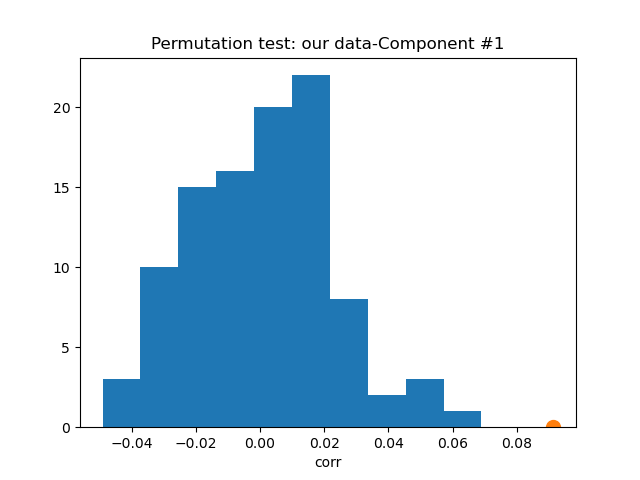

In [5]:
# Permutation test
from tqdm import tqdm
fold = 5
idx = 3
len_test = T // fold
X_test = eeg_multisub_concat[len_test*idx:len_test*(idx+1),:,:]
X_train = np.delete(eeg_multisub_concat, range(len_test*idx, len_test*(idx+1)), axis=0)
_, W_train, corr_train = utils.GCCA(X_train, n_components=n_components, regularization='lwcov')
_, _, corr_test = utils.GCCA(X_test, n_components=n_components, regularization='lwcov', W_train=W_train)
print("correlation coefficient = {}".format(corr_test))

num_test=100
corr_shuffle = np.zeros((num_test, n_components))
for i in tqdm(range(num_test)):
    X_test = utils.shuffle_block(X_test, t=1, fs=30)
    _, _, corr_shuffle[i,:] = utils.GCCA(X_test, n_components=n_components, regularization='lwcov', W_train=W_train)

compo = 1
signifi = sum(corr_shuffle[:,compo-1]>corr_test[compo-1])/num_test*100
print("Component {compo}, top {signifi}%".format(compo=compo, signifi=signifi))
plt.close()
plt.hist(corr_shuffle[:,compo-1])
plt.title('Permutation test: our data-'+'Component #'+str(compo))
plt.xlabel('corr')
plt.plot(corr_test[compo-1], 0, marker="o", markersize=10)
plt.show()


In [4]:
# 10-fold cross validation: correlated component analysis
fold = 10
ISC_train = np.zeros((fold, n_components))
ISC_test = np.zeros_like(ISC_train)
X_downsampled = eeg_multisub_concat
T, D, N = X_downsampled.shape
for i in range(fold):
    len_test = T // fold
    X_test = X_downsampled[len_test*i:len_test*(i+1),:,:]
    X_train = np.delete(X_downsampled, range(len_test*i, len_test*(i+1)), axis=0)
    ISC_train[i,:], W_train = utils.corr_component(X_train, n_components=n_components)
    ISC_test[i,:], _ = utils.corr_component(X_test, n_components=n_components, W_train=W_train)
print('Average correlation coefficients of the top {} components on the training sets: {}'.format(n_components, np.average(ISC_train, axis=0)))
print('Average correlation coefficients of the top {} components on the test sets: {}'.format(n_components, np.average(ISC_test, axis=0)))

Average correlation coefficients of the top 5 components on the training sets: [0.16690188 0.13208331 0.11893844 0.11123402 0.10673787]
Average correlation coefficients of the top 5 components on the test sets: [ 0.08951835  0.05592823 -0.0161508   0.00191595  0.0033559 ]


ISC = [0.12287261 0.04219399 0.00835634 0.04081128 0.00911728]


100%|██████████| 100/100 [00:04<00:00, 20.30it/s]


Component 2, top 2.0%


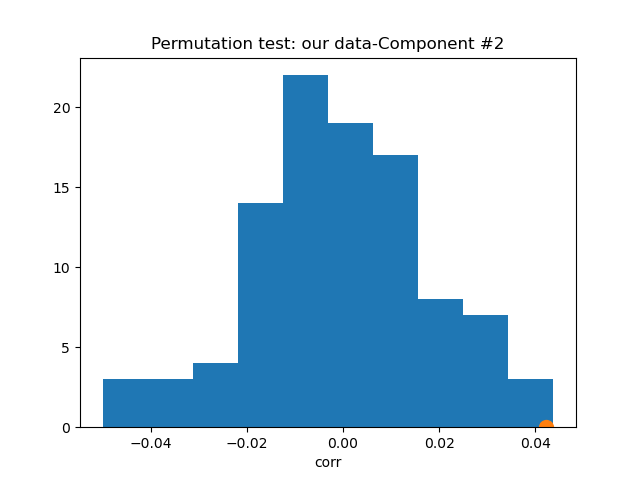

In [61]:
# Permutation test
fold = 5
idx = 3
len_test = T // fold
X_test = eeg_multisub_concat[len_test*idx:len_test*(idx+1),:,:]
X_train = np.delete(eeg_multisub_concat, range(len_test*idx, len_test*(idx+1)), axis=0)
ISC_train, W_train = utils.corr_component(X_train, n_components=n_components)
ISC_test, _ = utils.corr_component(X_test, n_components=n_components, W_train=W_train)
print("ISC = {}".format(ISC_test))

num_test=100
ISC_shuffle = np.zeros((num_test, n_components))
for i in tqdm(range(num_test)):
    X_test = utils.shuffle_block(X_test, t=1, fs=30)
    ISC_shuffle[i,:], _ = utils.corr_component(X_test, n_components=n_components, W_train=W_train)

compo = 2
signifi = sum(ISC_shuffle[:,compo-1]>ISC_test[compo-1])/num_test*100
print("Component {compo}, top {signifi}%".format(compo=compo, signifi=signifi))
plt.close()
plt.hist(ISC_shuffle[:,compo-1])
plt.title('Permutation test: our data-'+'Component #'+str(compo))
plt.xlabel('corr')
plt.plot(ISC_test[compo-1], 0, marker="o", markersize=10)
plt.show()


In [31]:
# export_path = '../../Experiments/data/AS/Videos/eeg_multi_sub.mat'
# scipy.io.savemat(export_path, {'eeg_multi_sub': eeg_multisub_concat, 'fs': fs})

In [35]:
clean_eeg_sub1 = loadmat('../../Experiments/data/AS/Videos/clean_eeg_sub1.mat')['clean_eeg']
clean_eeg_sub1 = np.expand_dims(clean_eeg_sub1.T, axis=2)
clean_eeg_sub2 = loadmat('../../Experiments/data/AS/Videos/clean_eeg_sub2.mat')['clean_eeg']
clean_eeg_sub2 = np.expand_dims(clean_eeg_sub2.T, axis=2)

In [36]:
clean_eeg_multisub = np.concatenate((clean_eeg_sub1,clean_eeg_sub2), axis=2)

In [39]:
ISC, W = utils.corr_component(clean_eeg_multisub, n_components, W_train=None)
ISC

array([0.15111508, 0.13060678, 0.11157034, 0.10637715, 0.10438172])